## Load libraries 

In [1]:
import pandas as pd
import numpy as np
import pickle
import os, time
from tqdm import tqdm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

import matplotlib as mpl
import matplotlib.pyplot as plt 
import missingno as msno
import seaborn as sns 
import copy

In [2]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})

In [3]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
[fm.FontProperties(fname=font).get_name() for font in font_list if 'D2C' in font]
plt.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

In [5]:
DATASET_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/dataset/'
load_dir = 'america_big_cities_health_inventory'
file_name = 'BigCitiesHealth.csv'
RSLT_DIR = '/home/doeun/code/AI/ESTSOFT2024/workspace/1.project1_structured/BCHI/processed/'
PVTB_DIR = RSLT_DIR + 'pvtb/'

- Funtions

In [6]:
import numpy as np

def mase(forecast, insample: np.ndarray, outsample, frequency:int=1) -> np.ndarray:
    """
    MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    :param forecast: Forecast values. Shape: batch, time_o
    :param insample: Insample values. Shape: batch, time_i
    :param outsample: Target values. Shape: batch, time_o
    :param frequency: Frequency value
    :return: Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(forecast - outsample)) / np.mean(np.abs(insample[:-frequency] - insample[frequency:]))

def mase_nontime(actual,pred,base_pred) -> np.ndarray:
    """
    MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    :param forecast: Forecast values. Shape: batch, time_o
    :param insample: Insample values. Shape: batch, time_i
    :param outsample: Target values. Shape: batch, time_o
    :param frequency: Frequency value
    :return: Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(actual - pred)) / np.mean(np.abs(actual - base_pred),)

In [7]:
import functools

def cond_check_dict(data=pd.DataFrame,val_dict=dict):
    cond_list=[
        data[col] == val
        for col, val in val_dict.items()
    ]
    return functools.reduce(lambda x,y: x & y, cond_list)

In [8]:
## FUNCTIONS - DATA- SCORE REG RSLT

def mase_nontime(actual,pred,base_pred) -> np.ndarray:
    """
    MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    :param forecast: Forecast values. Shape: batch, time_o
    :param insample: Insample values. Shape: batch, time_i
    :param outsample: Target values. Shape: batch, time_o
    :param frequency: Frequency value
    :return: Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(actual - pred)) / np.mean(np.abs(actual - base_pred),)

def make_reg_score_dict(y_actual,y_pred,base_val):
    rmse_model, rmse_base = np.sqrt(mse(y_actual,y_pred)), np.sqrt(mse([base_val]*len(y_actual),y_actual))
    mape_model, mape_base = mape(y_actual,y_pred), mape([base_val]*len(y_actual),y_actual)
    mase_model, mase_base = mase_nontime(y_actual,y_pred,base_val),1
    r2_model, r2_base = r2_score(y_actual,y_pred), 0
    
    return {
        'rmse' : [rmse_model, rmse_base],
        'mape' : [mape_model, mape_base],
        'mase' : [mase_model, mase_base],
        'r2_score' : [r2_model,r2_base]
    }

def print_reg_score_dict(name,dict_score,cut_line=True):
    print('{}\nr2 score : {:.5f}'.format(name,dict_score['r2_score'][0]))
    print('rmse_model : {:.5f} / rmse_base : {:.5f}\t'.format(*dict_score['rmse']),
          'mape_model : {:.5f} / mape_base : {:.5f}\t'.format(*dict_score['mape']))
    if cut_line : print('-'*150)

def make_reg_score_dict_cols(dict_data,dict_rslt,print_rslt=False):
    dict_score = dict()
    for col, val in dict_data.items():
        train_y = val['train']['y']
        valid_y = val['valid']['y']
        y_pred = dict_rslt[col]['valid']
        dict_score[col] = make_reg_score_dict(valid_y,y_pred,np.mean(train_y))
        if print_rslt : print_reg_score_dict(col,dict_score[col])
    return dict_score

- listing survey candidate labels

In [9]:
col_cand_list=[
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Income | Per-capita Household Income',
    'Language and Nativity | Primarily Speak English',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Cancer | All Cancer Deaths',
    'Cancer | Breast Cancer Deaths',
    'Cancer | Lung Cancer Deaths',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Language and Nativity | Primarily Speak Spanish',
    'Births | Teen Births',
    'Cancer | All Cancer Deaths',
    'Cancer | Breast Cancer Deaths',
    'Cancer | Lung Cancer Deaths',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Heat and Disasters | Community Social Vulnerability to Climate Disasters',
    'Income-related | Unemployment',
    'Language and Nativity | Primarily Speak Spanish',
    'Mental Health | Suicide',
    'Race/Ethnicity | Minority Population',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Income | Per-capita Household Income',
    'Language and Nativity | Primarily Speak English',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Income | Per-capita Household Income',
    'Language and Nativity | Primarily Speak English',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Income Inequality | Household Income Inequality',
    'Income | Households with Higher-Incomes',
    'Income | Per-capita Household Income',
    'Language and Nativity | Primarily Speak English',
    'Life Expectancy at Birth | Life Expectancy',
    'Substance Use | Adult Smoking',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Diabetes and Obesity | Diabetes Deaths',
    'Life Expectancy at Birth | Life Expectancy',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Diabetes and Obesity | Diabetes Deaths',
    'Language and Nativity | Foreign Born Population',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Adult Mental Distress',
    'Racial Segregation Indices | Racial Segregation, White and Non-White',
    'Respiratory Infection | COVID-19 Deaths',
    'Respiratory Infection | New Tuberculosis Cases',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Diabetes and Obesity | Diabetes Deaths',
    'Life Expectancy at Birth | Life Expectancy',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Diabetes and Obesity | Diabetes Deaths',
    'Language and Nativity | Foreign Born Population',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Adult Mental Distress',
    'Racial Segregation Indices | Racial Segregation, White and Non-White',
    'Respiratory Infection | COVID-19 Deaths',
    'Respiratory Infection | New Tuberculosis Cases',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Premature Death',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Suicide',
    'Substance Use | Drug Overdose Deaths',
    'Substance Use | Opioid Overdose Deaths',
    'Crime Incidents | Homicides',
    'Deaths | Deaths from All Causes',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Motor Vehicle Deaths',
    'Deaths | Premature Death',
    'Food Access | Limited Supermarket Access',
    'Language and Nativity | Foreign Born Population',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Suicide',
    'Sexually Transmitted Disease | New Gonorrhea Cases',
    'Substance Use | Drug Overdose Deaths',
    'Substance Use | Opioid Overdose Deaths',
    'Active Transportation | Walking to Work',
    'Deaths | Deaths from All Causes',
    'Deaths | Premature Death',
    'Education | Preschool Enrollment',
    'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
    'Transportation | Public Transportation Use',
    'Active Transportation | Walking to Work',
    'Deaths | Deaths from All Causes',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Infant Deaths',
    'Deaths | Premature Death',
    'Education | Preschool Enrollment',
    'Heat and Disasters | Longer Summers',
    'Income-related | Service Workers',
    'Language and Nativity | Primarily Speak Chinese',
    'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
    'Mental Health | Suicide',
    'Transportation | Public Transportation Use',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Crime Incidents | Homicides',
    'Deaths | Deaths from All Causes',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Injury Deaths',
    'Life Expectancy at Birth | Life Expectancy',
    'Births | Low Birthweight',
    'Births | Preterm Births',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Cardiovascular Disease | Heart Disease Deaths',
    'Crime Incidents | Homicides',
    'Crime Incidents | Violent Crime',
    'Deaths | Deaths from All Causes',
    'Deaths | Gun Deaths (Firearms)',
    'Deaths | Injury Deaths',
    'Deaths | Maternal Deaths',
    'Life Expectancy at Birth | Life Expectancy',
    'Mental Health | Adult Mental Distress',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Deaths from All Causes',
    'Education | College Graduates',
    'Income Inequality | Income Inequality',
    'Lead Poisoning | Housing Lead Risk',
    'Racial Segregation Indices | Racial Segregation, White and Black',
    'Cardiovascular Disease | Cardiovascular Disease Deaths',
    'Deaths | Deaths from All Causes',
    'Deaths | Racial Disparity in Police Killings',
    'Disability | People with Disabilities',
    'Education | College Graduates',
    'Income Inequality | Income Inequality',
    'Income-related | Service Workers',
    'Lead Poisoning | Housing Lead Risk',
    'Population | Single-Parent Families',
    'Race/Ethnicity | Minority Population',
    'Racial Segregation Indices | Racial Segregation, White and Black',
    'Racial Segregation Indices | Racial Segregation, White and Non-White',
    'Active Transportation | Riding Bike to Work',
    'Education | Preschool Enrollment',
    'Housing | Owner Occupied Housing',
    'Population | Population Density',
    'Race/Ethnicity | Minority Population',
    'Racial Segregation Indices | Racial Segregation, White and Black',
    'Active Transportation | Riding Bike to Work',
    'Education | Preschool Enrollment',
    'Housing | Homeless, Total',
    'Housing | Owner Occupied Housing',
    'Housing | Renters vs. Owners',
    'Income Inequality | Income Inequality',
    'Population | Population Density',
    'Race/Ethnicity | Minority Population',
    'Racial Segregation Indices | Racial Segregation, White and Black',
    'Racial Segregation Indices | Racial Segregation, White and Hispanic',
    'Transportation | Lack of Car',
    'Transportation | Longer Driving Commute Time',
    'Deaths | Injury Deaths',
    'Health Insurance | Uninsured, All Ages',
    'Housing | Homeless, Total',
    'Mental Health | Adult Mental Distress',
    'Sexually Transmitted Disease | Syphilis Prevalence',
    'Sexually Transmitted Disease | Syphilis, Newborns',
    'Deaths | Injury Deaths',
    'Health Insurance | Uninsured, All Ages',
    'Health Insurance | Uninsured, Child',
    'Housing | Homeless, Children',
    'Housing | Homeless, Total',
    'Housing | Vacant Housing and Homelessness',
    'Lead Poisoning | Child Lead Levels 5+ mcg/dL',
    'Mental Health | Adult Mental Distress',
    'Population | Children',
    'Sexually Transmitted Disease | Syphilis Prevalence',
    'Sexually Transmitted Disease | Syphilis, Newborns',
]


## Load k-NN regression result

In [10]:
pvtb_name = 'pvtb_city_encoded_ver1.csv'
pvtb_encoded = pd.read_csv(os.path.join(PVTB_DIR,pvtb_name),index_col=0)

cand_cols = list(set(col_cand_list))
entire_label = list(pvtb_encoded.columns)[9:]
target_cols = list(filter(lambda x : x in cand_cols,entire_label))

geo_name = 'geo_strat_info.csv'
geo_info_path = os.path.join(RSLT_DIR,geo_name)
geo_strat_info = pd.read_csv(geo_info_path, index_col=0)
city_list = list(geo_strat_info.index)

knn_dir = 'knn_rslt'
knn_path = os.path.join(RSLT_DIR,knn_dir)
work_idx = 0
n_work = 10

In [11]:
cand_cols = sorted(list(set(col_cand_list)))
entire_label = list(pvtb_encoded.columns)[9:]
info_cols = [
    'city_idx',
    'encoded_strata_race_label',
    'encoded_strata_sex_label',
    'encoded_geo_strata_region',
    'encoded_geo_strata_poverty',
    'encoded_geo_strata_Population',
    'encoded_geo_strata_PopDensity',
    'encoded_geo_strata_Segregation',
    'date_label',
]

metric, n_neigh = 'custom-1', 7
col_select = 'all'
if col_select == 'else' : target_cols = list(filter(lambda x : x not in cand_cols,entire_label))
elif col_select == 'cand' : target_cols = cand_cols
elif col_select == 'all': target_cols = entire_label

prjct_name = '{}-k{}_distance_{}'.format(metric,n_neigh,col_select)
n_work = 10 

### load pkl and make score dict

In [12]:
knn_path = os.path.join(RSLT_DIR,'knn',f'knn_{prjct_name}','pkl')
files = list(filter(lambda x : '.pkl' in x,os.listdir(knn_path)))

pvtb_encoded['city_idx'] = pvtb_encoded['geo_label_city'].apply(lambda x : city_list.index(x))
temp = list(pvtb_encoded.columns)
pvtb_encoded_whole = pvtb_encoded[['city_idx']+temp[1:-1]]
test_df = pvtb_encoded[info_cols+entire_label]

file_dict = dict()

keys = ['dict_rslt','dict_data']
for filename in files:
    if filename[-4:] != '.pkl' : continue
    key = list(filter(lambda x : x in filename,keys))[0]
    file_path = os.path.join(knn_path,filename)
    with open (file_path,'rb') as f:
        name = filename[len(key)+1:-4]
        if name in file_dict : file_dict[name][key] = pickle.load(f)
        else : file_dict[name] = {key : pickle.load(f)}
print(len(file_dict))

10


In [13]:
knn_score_dict = dict()
base_score_dict = dict()

for key,ele_dict in tqdm(file_dict.items()):
    dict_rslt = ele_dict['dict_rslt']
    dict_data = ele_dict['dict_data']
    target_sample= list(dict_rslt.keys())
    print(key,target_sample)
    rslt_form = test_df[info_cols+target_sample]

    for col in target_sample:
        cond = test_df[col].isna()
        loaded = dict_rslt[col]['target']
        assert np.sum(cond) == len(loaded)  
        rslt_form.loc[cond,col] = loaded


100%|██████████| 10/10 [00:00<00:00, 61.46it/s]

custom-1-k7_distance_all_10_1 ['Active Transportation | Walking to Work', 'Cancer | Colorectal Cancer Deaths', 'Deaths | Infant Deaths', 'Diabetes and Obesity | Teen Obesity', 'Heat and Disasters | Community Social Vulnerability to Climate Disasters', 'Income Inequality | Income Inequality', 'Language and Nativity | Foreign Born Population', 'Mental Health | Electronic Bullying', 'Physical Activity | Teen Physical Inactivity', 'Racial Segregation Indices | Racial Segregation, White and Non-White', 'Sexually Transmitted Disease | HIV-Related Deaths', 'Substance Use | Teen Alcohol']
custom-1-k7_distance_all_10_0 ['Active Transportation | Riding Bike to Work', 'Cancer | Breast Cancer Deaths', 'Deaths | Gun Deaths (Firearms)', 'Diabetes and Obesity | Diabetes Deaths', 'Heat and Disasters | Climate-related  Disasters', 'Income Inequality | Household Income Inequality', 'Income-related | Unemployment', 'Mental Health | Adult Mental Distress', 'Physical Activity | Teen Physical Education', 'R

In [18]:

for key,ele_dict in tqdm(file_dict.items()):
    dict_df = dict()
    dict_rslt = ele_dict['dict_rslt']
    dict_data = ele_dict['dict_data']
    target_sample= list(dict_rslt.keys())
    
    for col in target_sample:
        temp = test_df[info_cols+[col]]
        cond_na = temp.isna().any(axis=1)
        dict_df[col] = {
            'train' : dict_data[col]['train'],
            'target' : dict_data[col]['target'],
        }
    
    ## check score
    dict_score = make_reg_score_dict_cols(dict_data,dict_rslt)
    
    knn_score = copy.deepcopy(dict_score)
    base_score = copy.deepcopy(dict_score)
    for key in dict_score.keys():
        for key2 in dict_score[key].keys():
            knn_score[key][key2] = knn_score[key][key2][0]
            base_score[key][key2] = base_score[key][key2][1]
        knn_score[key]['n_size'] = len(dict_data[key]['train']['X'])
    
    knn_score_dict = {**knn_score_dict,**knn_score}
    base_score_dict = {**base_score_dict,**base_score}

100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


In [19]:
def nested_dict_to_df(data:dict,sep='$'):
    df_in = pd.json_normalize(data,sep=sep)
    df_in.columns = df_in.columns.str.split(sep, expand=True)
    df_reform = df_in.loc[0]
    return df_reform.reset_index()
    

In [23]:
knn_score_dict['Cancer | Colorectal Cancer Deaths']

{'rmse': 2.774177535608701,
 'mape': 0.13183821215607172,
 'mase': 0.49728515996418676,
 'r2_score': 0.7080124119505664,
 'n_size': 4034}

In [20]:
knn_score = nested_dict_to_df(knn_score_dict)

## PLOT 

In [21]:
knn_score

,level_0,level_1,0
0,Active Transportation | Walking to Work,rmse,3.245704e+00
1,Active Transportation | Walking to Work,mape,2.267019e+14
2,Active Transportation | Walking to Work,mase,5.961224e-01
3,Active Transportation | Walking to Work,r2_score,3.406547e-01
4,Active Transportation | Walking to Work,n_size,1.762000e+03
...,...,...,...
585,Substance Use | Drug Overdose Deaths,rmse,1.664070e+01
586,Substance Use | Drug Overdose Deaths,mape,3.435383e-01
587,Substance Use | Drug Overdose Deaths,mase,4.851639e-01
588,Substance Use | Drug Overdose Deaths,r2_score,6.964459e-01


In [28]:
pvtb = pd.pivot_table(knn_score,index='level_0',columns='level_1',values=0)
pvtb.loc[pvtb['mape'] > 10000,'mape'] = 2.5
#pvtb.dropna(inplace = True)

In [29]:
len(pvtb)

118

In [30]:
np.sum(pvtb['r2_score'] > 0.85)

2

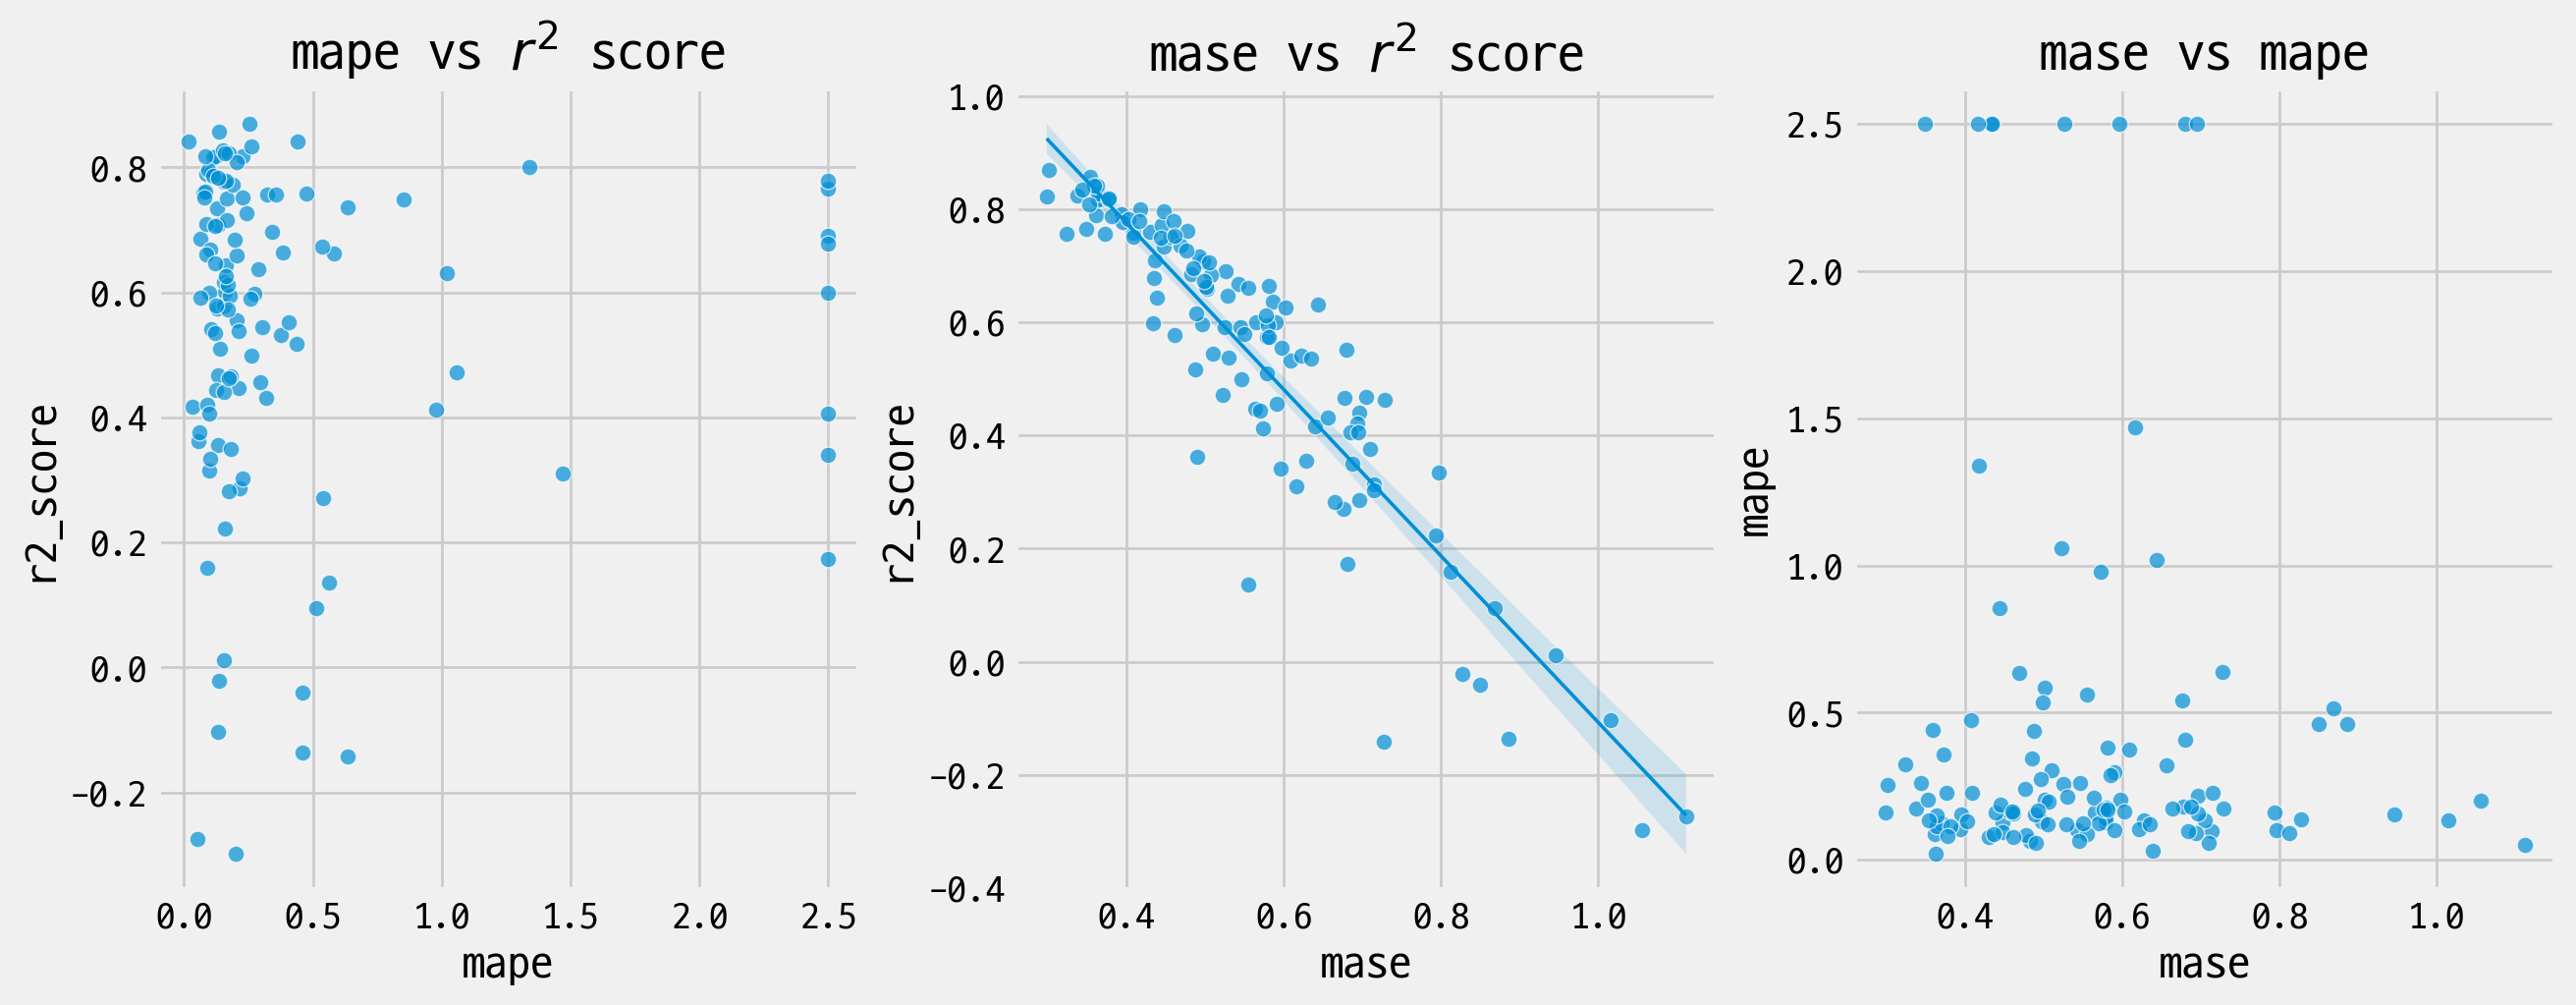

In [31]:
fig,axes = plt.subplots(1,3,figsize=(13,5))
sns.scatterplot(data=pvtb, x='mape', y='r2_score',ax=axes[0],alpha = 0.7)
axes[0].set_title(r'mape vs $r^2$ score')
sns.regplot(data=pvtb, x='mase', y='r2_score',ax=axes[1],scatter=False,line_kws={'lw':1.3})
sns.scatterplot(data=pvtb, x='mase', y='r2_score',ax=axes[1],alpha = 0.7)
axes[1].set_title(r'mase vs $r^2$ score')
sns.scatterplot(data=pvtb, x='mase', y='mape',ax=axes[2], alpha = 0.7)
axes[2].set_title('mase vs mape')
pass

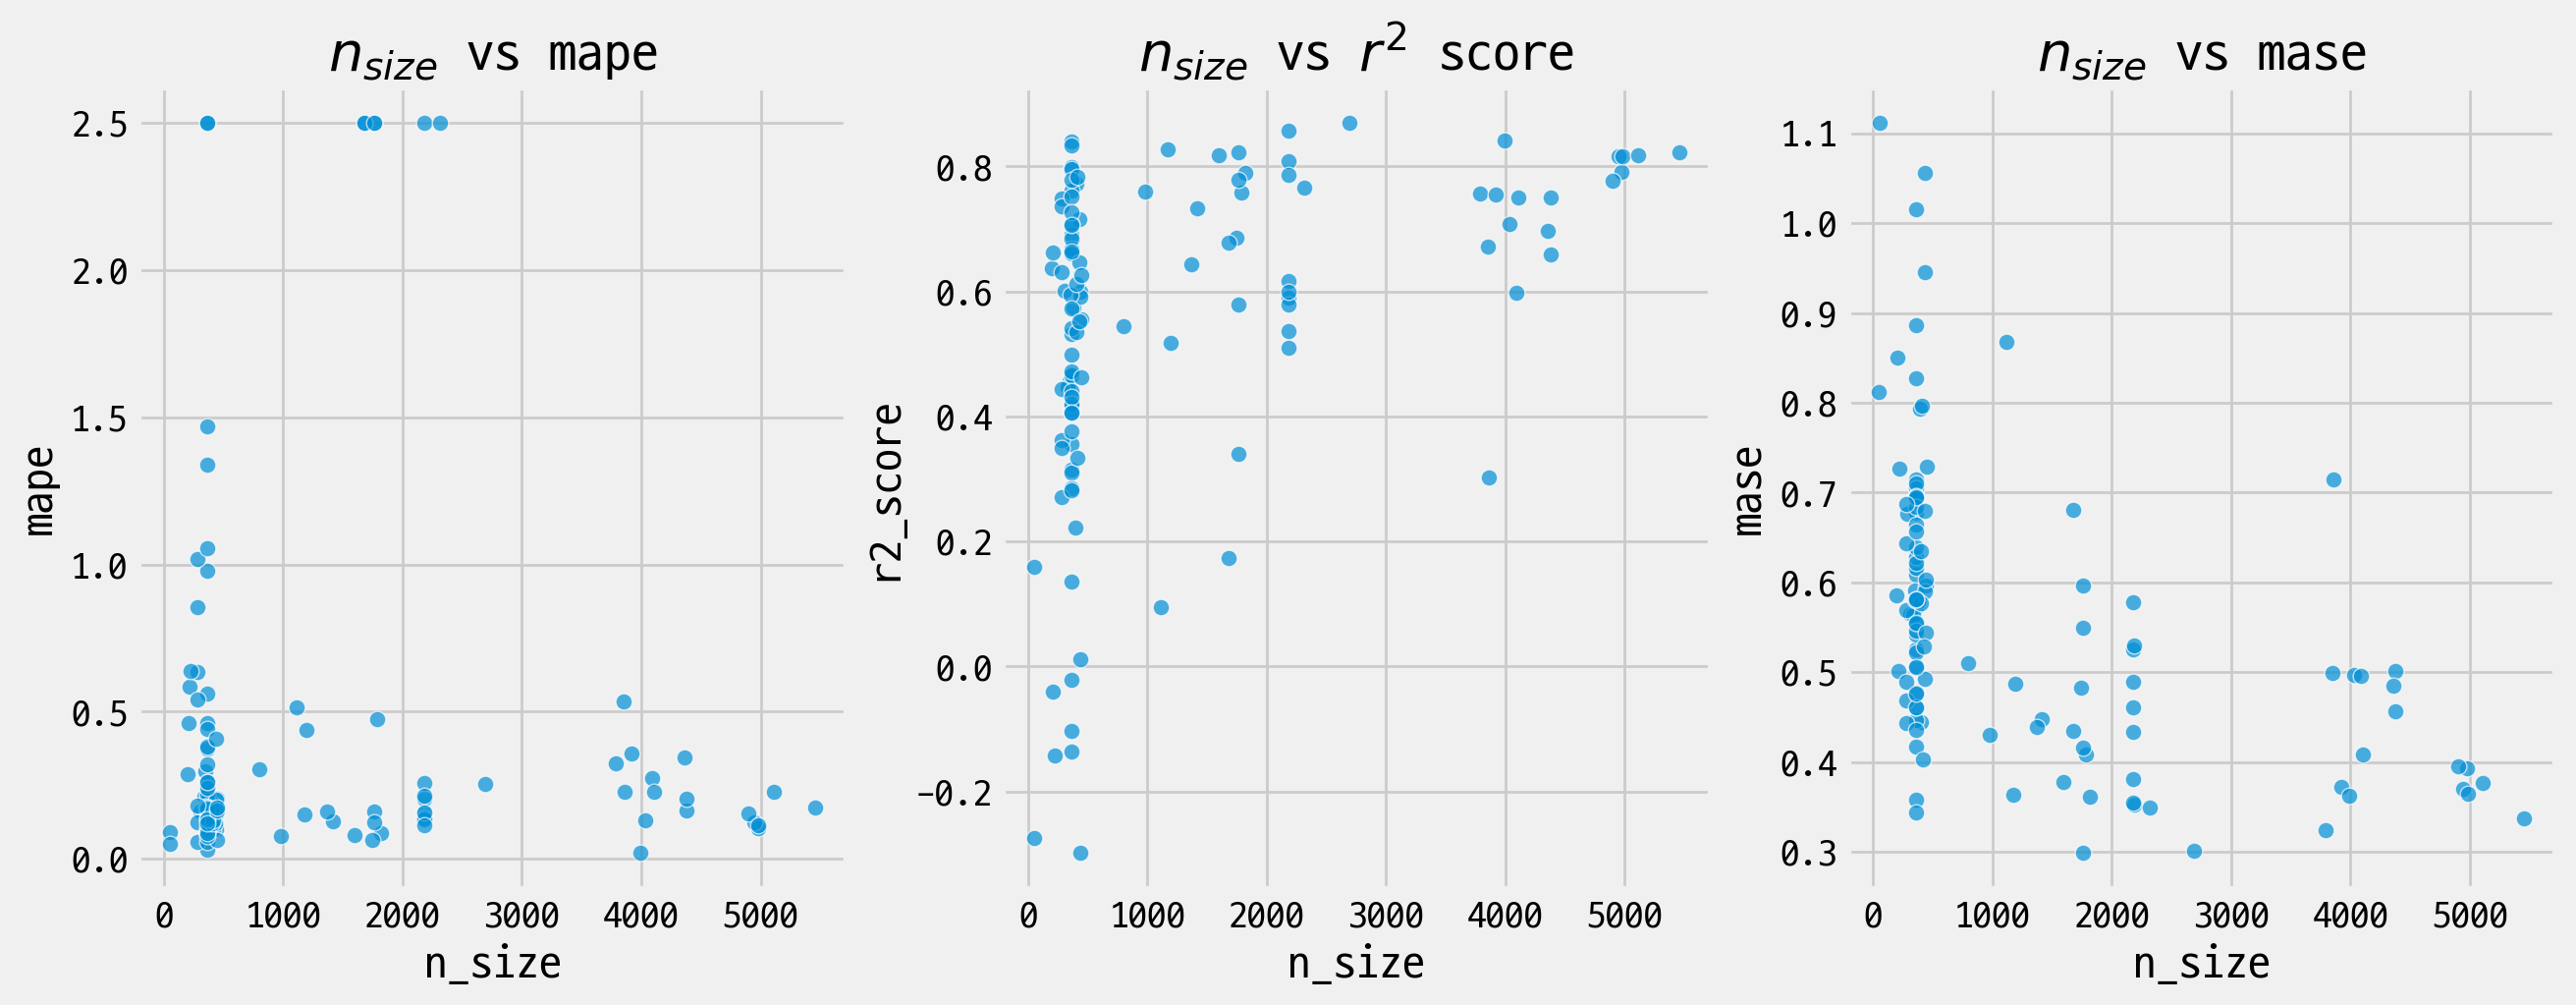

In [33]:
fig,axes = plt.subplots(1,3,figsize=(13,5))
sns.scatterplot(data=pvtb, x='n_size', y='mape',ax=axes[0],alpha = 0.7)
axes[0].set_title(r'$n_{size}$ vs mape')
sns.scatterplot(data=pvtb, x='n_size', y='r2_score',ax=axes[1],alpha = 0.7)
axes[1].set_title(r'$n_{size}$ vs $r^2$ score')
sns.scatterplot(data=pvtb, x='n_size', y='mase',ax=axes[2], alpha = 0.7)
axes[2].set_title(r'$n_{size}$ vs mase')
pass

In [74]:
from scipy.stats import linregress

slope,intercept,r,p,sterr = linregress(x=pvtb['mase'],y=pvtb['r2_score'])

slope,intercept,r,p,sterr

(-1.471570641685723,
 1.3641247078755396,
 -0.9159882393789934,
 7.883000846181495e-48,
 0.05984511215906661)

$$
\text{MASE} = \text{mean}\left(\frac{\vert e_j \vert}{\text{mean}(\vert Y-\bar{Y}\vert)}\right)
$$

and

$$
R^2 \text{ score} = 1- \frac{\text{mean}\left(e_j^2\right)}{\text{mean}\left(\vert Y-\bar{Y} \vert ^2\right)}
$$.

By the linear regression between MASE and $R^2$ score we got from the above cell,

$$
\frac{\text{mean}\left(\vert e_j\vert^2\right)}{\text{mean}\left(\vert Y-\bar{Y} \vert ^2\right)} \approx\text{mean}\left(\frac{\vert e_j \vert}{\text{mean}(\vert Y-\bar{Y}\vert)}  \right) = \frac{\text{mean}(\vert e_j \vert)}{\text{mean}(\vert Y-\bar{Y}\vert)}
$$

for each $Y$ is actual values and $e_j$ is error of predicted value by kNN for labels.

Since $\text{mean}(X^2) =\alpha \cdot \text{mean}(X)$ implies $\alpha = \text{mean}(X)+\frac{\text{Var}(X)}{\text{mean(X)}}$,

$$
\text{mean}(\vert e_j \vert) +\frac{\text{Var}(\vert e_j \vert)} {\text{mean}(\vert e_j \vert)} =
\text{mean}(\vert Y-\bar{Y}\vert) + \frac {\text{Var}(\vert Y-\bar{Y}\vert)} {\text{mean}(\vert Y-\bar{Y}\vert)}
$$



would it has any meaning for distributions or else ... ? idk..........

## Load k-NN regression result 2

In [ ]:
#knn_score_dict2=dict()
#base_score_dict2=dict()


for key,ele_dict in tqdm(file_dict.items()):
    dict_rslt = ele_dict['dict_rslt']
    dict_train_test = ele_dict['dict_train_test']
    target_sample= list(dict_rslt.keys())
    rslt_form = test_df[info_cols+target_sample]

    for col in target_sample:
        cond = test_df[col].isna()
        loaded = dict_rslt[col]['target']
        assert np.sum(cond) == len(loaded)  
        rslt_form.loc[cond,col] = loaded

    dict_df = dict()
    for col in target_sample:
        temp = test_df[info_cols+[col]]
        cond_na = temp.isna().any(axis=1)
        dict_df[col] = {
            'train' : [temp.loc[~cond_na,info_cols], temp.loc[~cond_na,col]],
            'target' : [temp.loc[cond_na,info_cols], cond_na],
        }
    
    ## check score
    dict_score = make_reg_score_dict_cols(target_sample,dict_df,dict_train_test,dict_rslt,print_plot=False)
    
    knn_score = copy.deepcopy(dict_score)
    base_score = copy.deepcopy(dict_score)
    for key in dict_score.keys():
        for key2 in dict_score[key].keys():
            knn_score[key][key2] = knn_score[key][key2][0]
            base_score[key][key2] = base_score[key][key2][1]
    
    knn_score_dict = {**knn_score_dict,**knn_score}
    base_score_dict = {**base_score_dict,**base_score}

100%|██████████| 10/10 [00:00<00:00, 21.77it/s]


In [78]:
knn_score = nested_dict_to_df(knn_score_dict)

## PLOT 

In [103]:
pvtb = pd.pivot_table(knn_score,index='level_0',columns='level_1',values=0)
pvtb.loc[pvtb['mape'] > 10000,'mape'] = 2.5
#pvtb.dropna(inplace = True)

In [96]:
len(pvtb)

118

In [97]:
np.sum(pvtb['r2_score'] > 0.80)

13

In [106]:
np.sum(pvtb['r2_score'] >= 0.70)

40

In [99]:
np.sum(pvtb['r2_score'] > 0.60)

59

In [100]:
np.sum(pvtb['r2_score'] > 0.50)

78

In [107]:
np.sum(pvtb['r2_score'] < 0.30)

16

In [119]:
np.sum(pvtb['mape'] > 0.6)

16

In [112]:
np.sum(pvtb['mape'] < 0.3)

84

In [114]:
np.sum(pvtb['mape'] < 0.25)

77

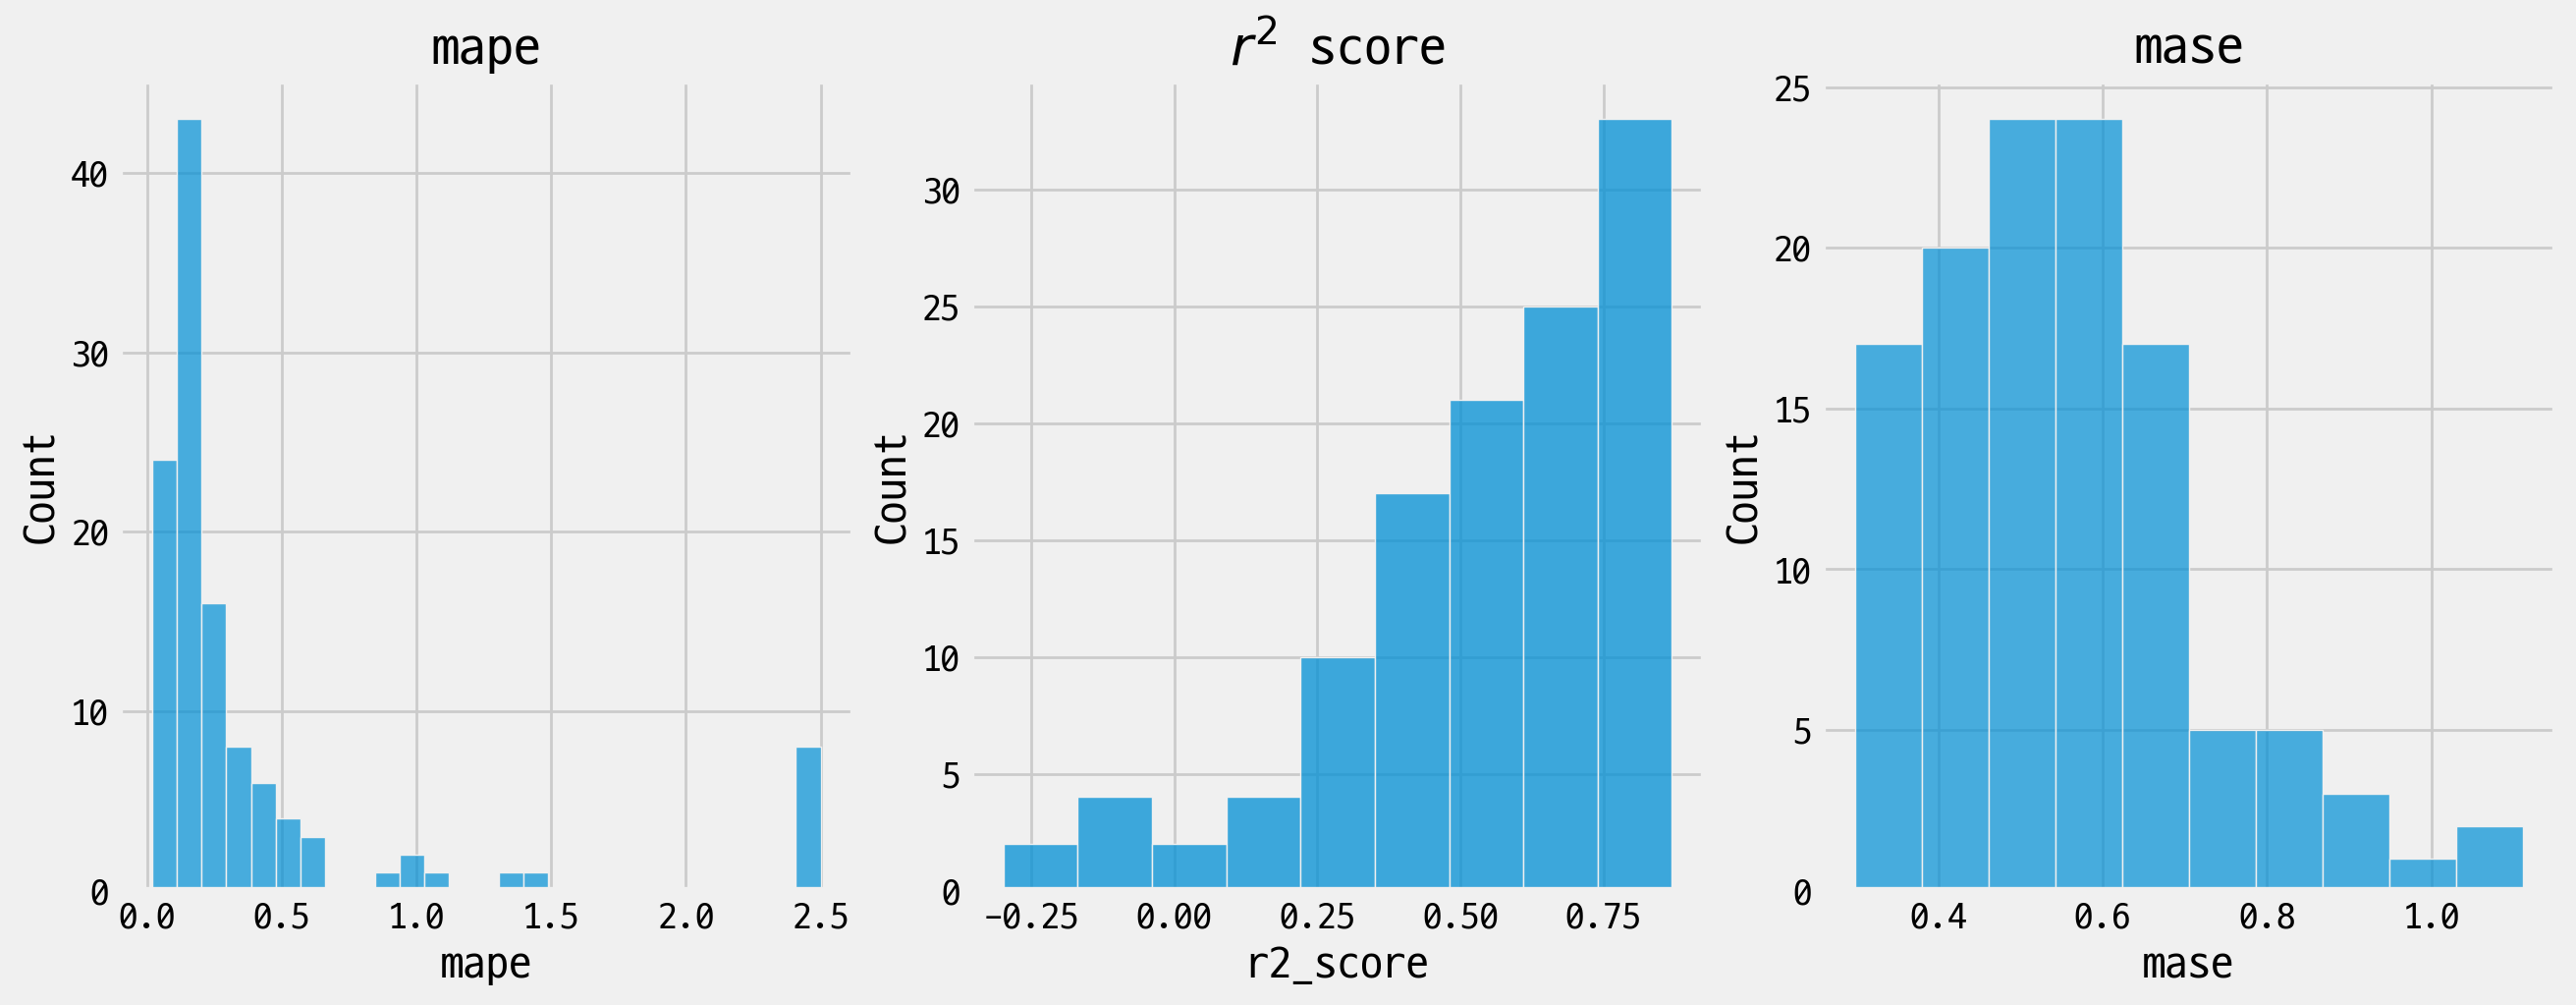

In [104]:
fig,axes = plt.subplots(1,3,figsize=(13,5))
sns.histplot(data=pvtb, x='mape', ax=axes[0],alpha = 0.7)#,label='cand')
axes[0].set_title(r'mape')
sns.histplot(data=pvtb, x='r2_score',ax=axes[1])
axes[1].set_title(r'$r^2$ score')
sns.histplot(data=pvtb, x='mase', ax=axes[2], alpha = 0.7)#,label='cand')
axes[2].set_title('mase')
pass

In [82]:
#fig,axes = plt.subplots(1,3,figsize=(13,5))
#sns.scatterplot(data=pvtb, x='mape', y='r2_score',ax=axes[0],alpha = 0.7,label='cand')
#sns.scatterplot(data=pvtb2, x='mape', y='r2_score',ax=axes[0],alpha = 0.7,label='else')
#axes[0].set_title(r'mape vs $r^2$ score')
#sns.regplot(data=pvtb, x='mase', y='r2_score',ax=axes[1],scatter=False,line_kws={'lw':1.3})
#sns.scatterplot(data=pvtb, x='mase', y='r2_score',ax=axes[1],alpha = 0.6,label='cand')#,s=)
#sns.scatterplot(data=pvtb2, x='mase', y='r2_score',ax=axes[1],alpha = 0.6,label='else')#,s=200)
#axes[1].set_title(r'mase vs $r^2$ score')
#sns.scatterplot(data=pvtb, x='mase', y='mape',ax=axes[2], alpha = 0.7,label='cand')
#sns.scatterplot(data=pvtb2, x='mase', y='mape',ax=axes[2], alpha = 0.7,label='else')
#axes[2].set_title('mase vs mape')
#axes[2].legend()
#pass

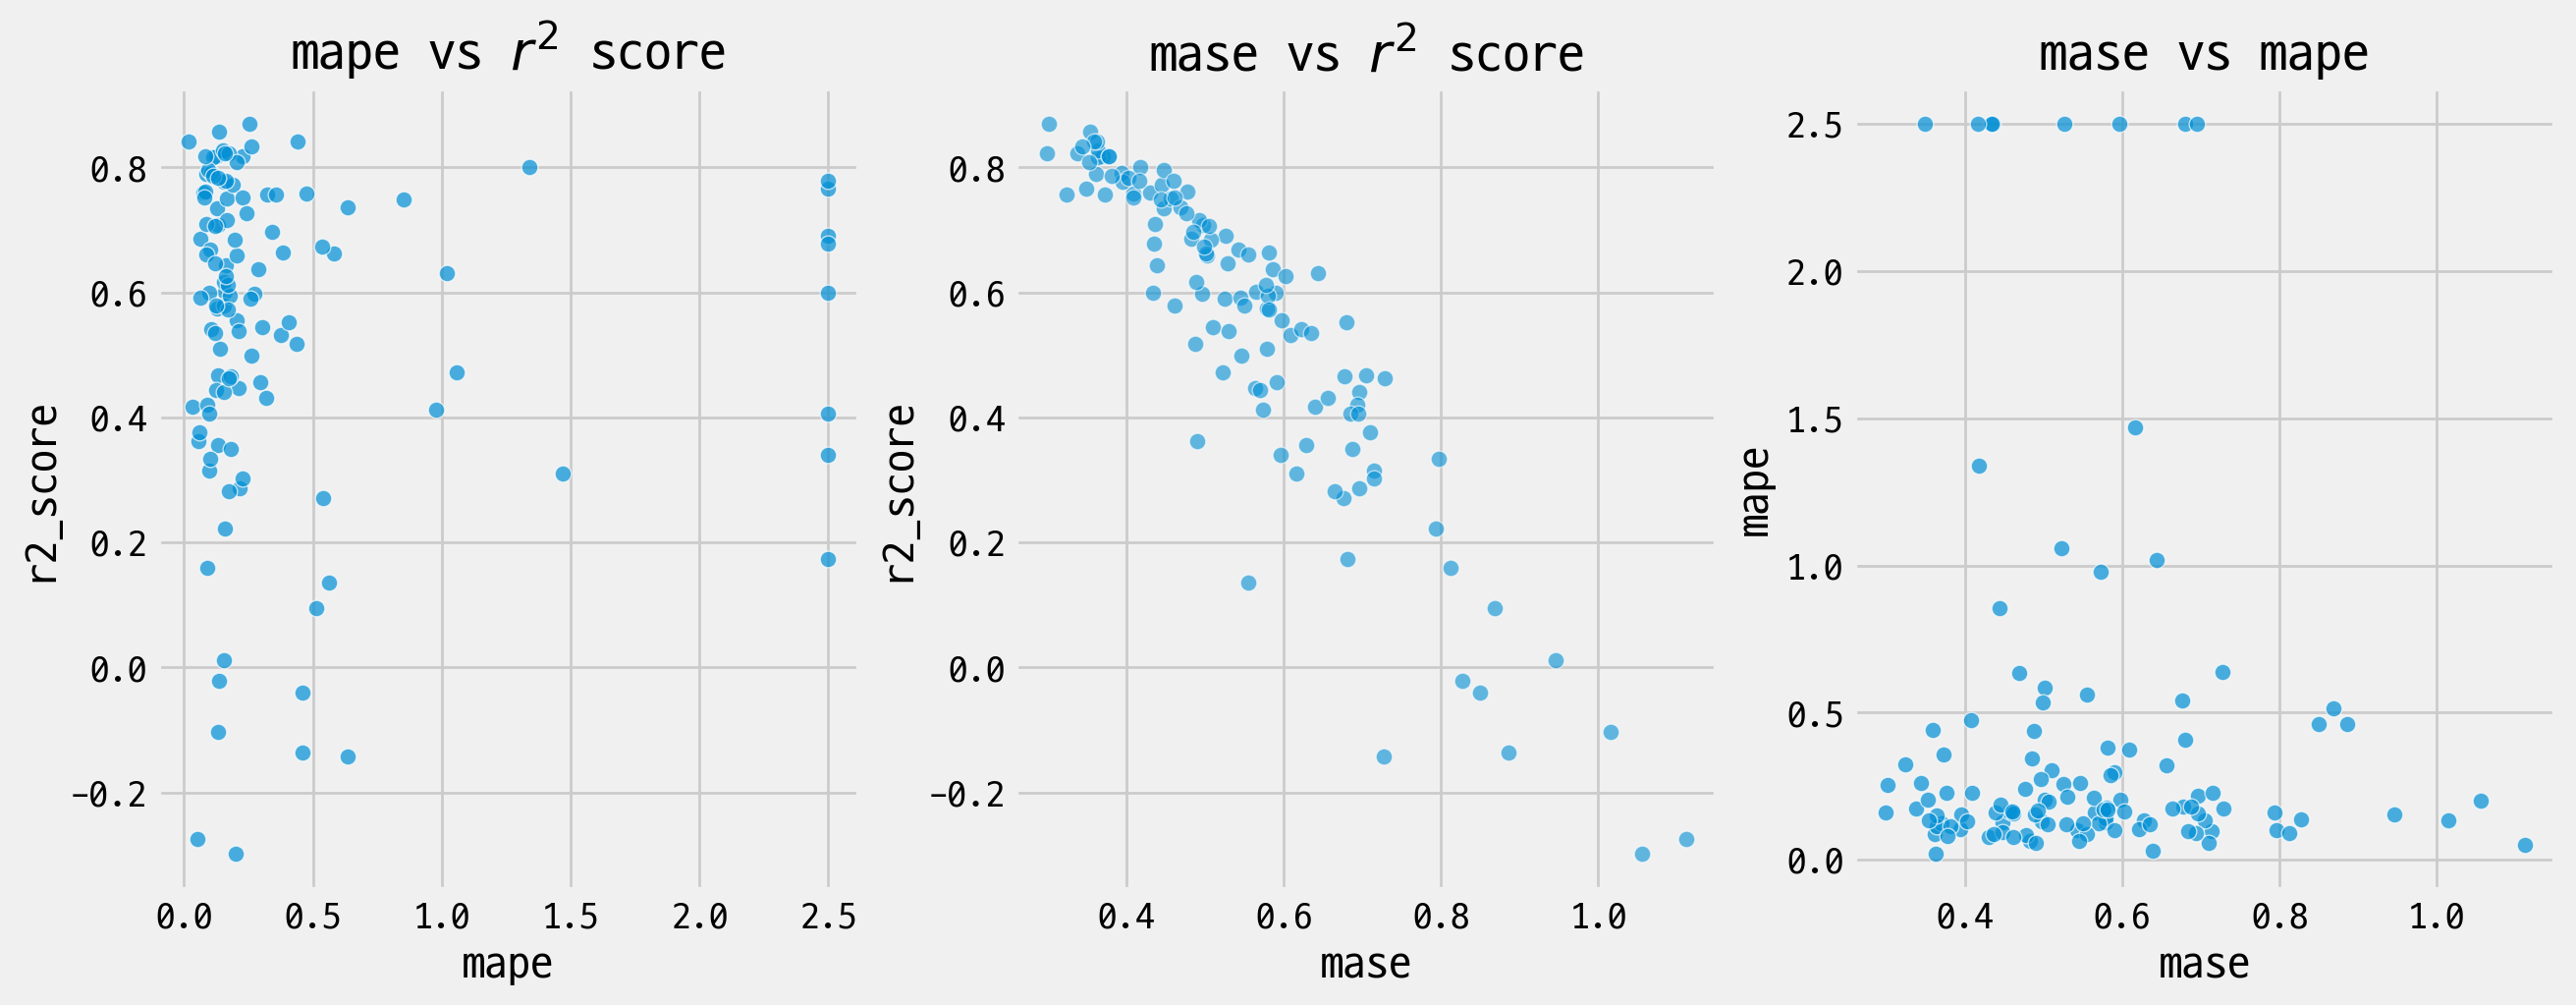

In [105]:
fig,axes = plt.subplots(1,3,figsize=(13,5))
sns.scatterplot(data=pvtb, x='mape', y='r2_score',ax=axes[0],alpha = 0.7)#,label='cand')
axes[0].set_title(r'mape vs $r^2$ score')
#sns.regplot(data=pvtb, x='mase', y='r2_score',ax=axes[1],scatter=False,line_kws={'lw':1.3})
sns.scatterplot(data=pvtb, x='mase', y='r2_score',ax=axes[1],alpha = 0.6)#,label='cand')#,s=)
axes[1].set_title(r'mase vs $r^2$ score')
sns.scatterplot(data=pvtb, x='mase', y='mape',ax=axes[2], alpha = 0.7)#,label='cand')
axes[2].set_title('mase vs mape')
pass

In [84]:
from scipy.stats import linregress

slope,intercept,r,p,sterr = linregress(x=pvtb['mase'],y=pvtb['r2_score'])

slope,intercept,r,p,sterr

(-1.471570641685723,
 1.3641247078755396,
 -0.9159882393789934,
 7.883000846181495e-48,
 0.05984511215906661)

In [ ]:
np.sum(pvtb['r2_score'] > 0.80)

73

In [ ]:
pvtb

level_1,mape,mase,r2_score,rmse
level_0,,,,
Active Transportation | Riding Bike to Work,0.702777,0.446772,0.577958,0.837664
Active Transportation | Walking to Work,NaN,0.378394,0.738007,1.922871
Air Pollution | Hazardous Air Quality,NaN,0.308656,0.787862,2.456944
Air Pollution | Poor Air Quality,0.230696,0.427788,0.718626,10.001380
Birth Control | Teen Birth Control,0.027093,0.071751,0.976362,0.998605
...,...,...,...,...
Substance Use | Teen Smoking,0.067215,0.090830,0.970219,0.690058
Transportation | Drives Alone to Work,0.079912,0.364368,0.786609,7.329781
Transportation | Lack of Car,0.170870,0.227112,0.933248,2.863528


In [ ]:
pvtb2

level_1,mape,mase,r2_score,rmse
level_0,,,,
Air Pollution | Hazardous Air Quality,NaN,0.308656,0.787862,2.456944
Air Pollution | Poor Air Quality,0.230696,0.427788,0.718626,10.001380
Birth Control | Teen Birth Control,0.027093,0.071751,0.976362,0.998605
Births | Prenatal Care,0.042759,0.342067,0.808303,4.676896
Cancer | Colorectal Cancer Deaths,0.073363,0.273725,0.864229,1.886979
Cancer | Prostate Cancer Deaths,0.073862,0.191775,0.919541,3.803480
Cardiovascular Disease | High Blood Pressure,0.075710,0.510487,0.693356,3.403652
Deaths | Police Killings,0.251555,0.307651,0.835029,0.691645
Diabetes and Obesity | Adult Obesity,0.071995,0.353892,0.840824,2.939810


In [ ]:
tot = pd.concat([pvtb,pvtb2])

len(tot)

169

In [ ]:
np.sum(tot.duplicated())

51

In [ ]:
len(pvtb)

118

In [ ]:
(tot.index).value_counts()

level_0
Respiratory Infection | Flu Vaccinations, Medicare                          2
Respiratory Infection | Pneumonia or Influenza Deaths                       2
Dietary Quality | Teen Breakfast                                            2
Dietary Quality | Teen Soda                                                 2
Mental Health | Electronic Bullying                                         2
                                                                           ..
Housing | Homeless, Children                                                1
Heat and Disasters | Longer Summers                                         1
Heat and Disasters | Community Social Vulnerability to Climate Disasters    1
Health Insurance | Uninsured, Child                                         1
Transportation | Public Transportation Use                                  1
Name: count, Length: 118, dtype: int64

In [ ]:
tot = tot.drop_duplicates(keep='first')

In [ ]:
np.sum(tot['r2_score'] > 0.60)

108